# Time Sereis -LSTM Analysis on Tesla Stock Price Dataset
#### Data consists of the monthly stock price of Tesla from 9/30/2019 to 4/11/2022. The data is arranged in 7 columns.
#### Dataset was collected from kaggle-'Tesla_StockPrice'
#### Model used here is time series lstm for predicting the future values based on the previously attained/available values.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt 


In [2]:
df=pd.read_csv(r"D:\DIGITAL SEM 3\Extra Projects\Datasets\Tesla.csv - Tesla.csv.csv")

In [3]:
df

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1687,3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988


#### Removing the unwanted columns so, that we can form a dataset that can be used for time series analysis.

In [4]:
df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)

#### Converting the given date columns into a datetime format using the available in built library.

In [5]:
from datetime import datetime
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True)

#### Setting the 'Date' Column as the index of the dataset

In [6]:
df=df.set_index('Date')

In [7]:
df.isnull().sum()

Close    0
dtype: int64

<AxesSubplot:xlabel='Date'>

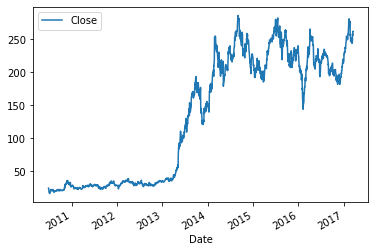

In [8]:
df.plot()

Fromt the graph we can see that there is a increasing trend in the 'Close' Column values.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1692 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


In [10]:
df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


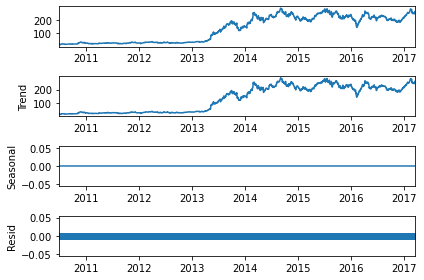

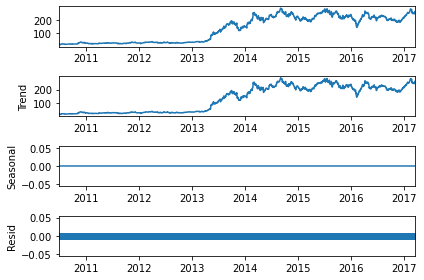

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decomp=seasonal_decompose(df,model='additive',period=1)
seasonal_decomp.plot()

In [12]:
# Performing Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
print('Result of Dickey-Fuller test:')
dftest=adfuller(df['Close'],autolag='AIC')

dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]=value
    
print(dfoutput)

Result of Dickey-Fuller test:
Test Statistic                   -0.813733
p-value                           0.815055
Lags Used                         0.000000
Number of Observations Used    1691.000000
Critical Value(1%)               -3.434223
Critical Value(5%)               -2.863251
Critical Value(10%)              -2.567681
dtype: float64


#### The p-value is greater than 0.05, based ont he result that we got from  the augmented dickey fuller test 

In [13]:
#taking the rolling stastistics, rolling window
rollingmean=df.rolling(window=15).mean()

In [14]:
new_df=(df-rollingmean).dropna()
new_df

,Close
Date,
2010-07-20,0.738666
2010-07-21,0.903333
2010-07-22,1.872000
2010-07-23,2.206668
2010-07-26,1.750001
...,...
2017-03-13,-6.737337
2017-03-14,6.385332
2017-03-15,5.300663


In [15]:
# Performing Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
print('Result of Dickey-Fuller test:')
dftest=adfuller(new_df['Close'],autolag='AIC')

dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]=value
    
print(dfoutput)

Result of Dickey-Fuller test:
Test Statistic                -1.008001e+01
p-value                        1.195506e-17
Lags Used                      2.000000e+00
Number of Observations Used    1.675000e+03
Critical Value(1%)            -3.434260e+00
Critical Value(5%)            -2.863267e+00
Critical Value(10%)           -2.567689e+00
dtype: float64


##### We can from the above augment-dickey fuller test that the p-value is less than 0.05

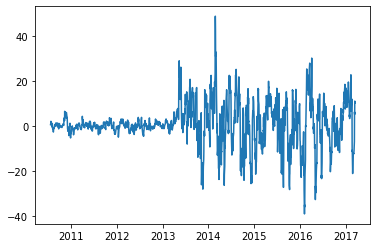

In [16]:
plt.plot(new_df)

#### We can see from the plot that the data is convereted tostationary and thus further anaysis can be done 

In [17]:
print(len(new_df))

1678


<AxesSubplot:xlabel='Date'>

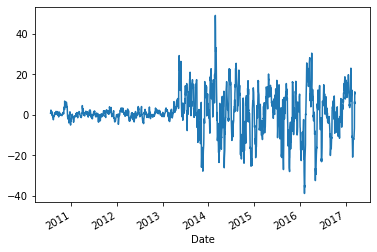

In [18]:
k=new_df['Close']
k.plot()

In [19]:
# creating a window
# A few of the input can be used to generate the next value 
# Eg: consider window size=5, so using this window size we will be abe to predict the next value,i.e 6th value


def df_to_X_y(df, window_size):    #the default value for window_size can also be provided,eg:window_size=5
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)


In [20]:
window_size = 5   #we are giving the size as 5
X, y = df_to_X_y(k, window_size)
X.shape, y.shape

((1673, 5, 1), (1673,))

### Splitting the dataset for testing, training & validation

#### Training ------>920 , Validation----->335 , Testing--------->418

In [21]:
X_train, y_train = X[:920], y[:920]
X_val, y_val = X[920:1255], y[920:1255]
X_test, y_test = X[1255:], y[1255:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((920, 5, 1), (920,), (335, 5, 1), (335,), (418, 5, 1), (418,))

### Creating the LSTM model

In [22]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import *


n_input = 5
n_features = 1

lstm_model = Sequential()
lstm_model.add(LSTM(400, activation = 'relu', input_shape = (n_input, n_features)))
lstm_model.add(Dense(1))


lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 400)               643200    
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________


In [23]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.losses import MeanSquaredError
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model



cp = ModelCheckpoint('lstm_model/', save_best_only = True)
lstm_model.compile(optimizer='adam', loss='mse', metrics = [RootMeanSquaredError()])

In [24]:
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, callbacks = [cp])

Epoch 1/20
29/29 [==============================] - 8s 101ms/step - loss: 23.6208 - root_mean_squared_error: 4.8601 - val_loss: 61.4610 - val_root_mean_squared_error: 7.8397
INFO:tensorflow:Assets written to: lstm_model\assets
Epoch 2/20
29/29 [==============================] - 2s 73ms/step - loss: 17.6781 - root_mean_squared_error: 4.2045 - val_loss: 49.2946 - val_root_mean_squared_error: 7.0210
INFO:tensorflow:Assets written to: lstm_model\assets
Epoch 3/20
29/29 [==============================] - 2s 73ms/step - loss: 13.9298 - root_mean_squared_error: 3.7323 - val_loss: 44.9314 - val_root_mean_squared_error: 6.7031
INFO:tensorflow:Assets written to: lstm_model\assets
Epoch 4/20
29/29 [==============================] - 2s 76ms/step - loss: 12.3284 - root_mean_squared_error: 3.5112 - val_loss: 46.5817 - val_root_mean_squared_error: 6.8251
Epoch 5/20
29/29 [==============================] - 2s 76ms/step - loss: 11.6148 - root_mean_squared_error: 3.4080 - val_loss: 36.6214 - val_root_me

##### From the above result, we can infer that the Root Mean Squared Error decreases through the number of epochs. Even though it increases at certain point, the general trend is the decrease in the value of Root Mean Squared Error.

In [25]:
lstm_model= load_model('lstm_model')
lstm_model

### Predicting the values with the training dataset 

In [26]:
train_predictions = lstm_model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actual Closing Values':y_train})
train_results

,Train Predictions,Actual Closing Values
0,1.389730,1.053999
1,0.916844,0.895999
2,0.701282,0.333334
3,0.199905,-0.245999
4,-0.241513,0.476000
...,...,...
915,-10.770448,-10.889337
916,-7.510889,-4.298673
917,-3.913779,-7.354669
918,-6.190625,-7.109329


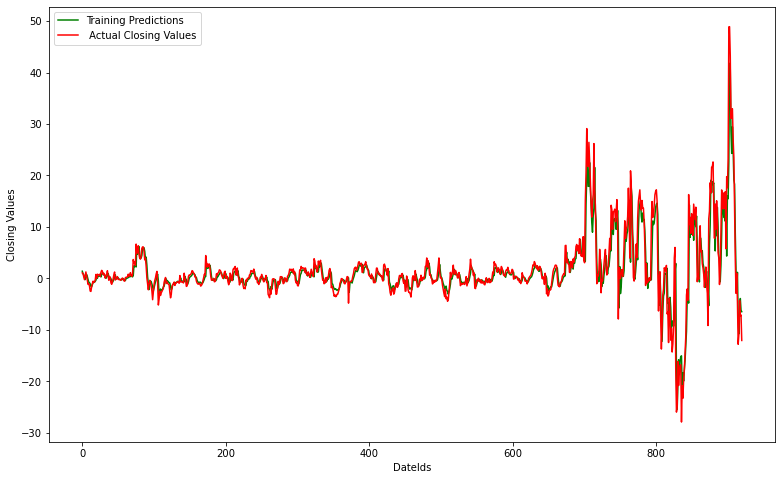

In [27]:
plt.figure(figsize = (13, 8))
plt.plot(train_results['Train Predictions'], label = 'Training Predictions', color = 'green')
plt.plot(train_results['Actual Closing Values'], label = ' Actual Closing Values', color = 'red')
plt.xlabel('DateIds')
plt.ylabel('Closing Values')
plt.legend()
plt.show()

### Predicting with Validation dataset 

In [28]:
val_predictions = lstm_model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Validation Predictions': val_predictions, 'Actual Closing Values':y_val})
val_results

,Validation Predictions,Actual Closing Values
0,-9.904269,-18.762002
1,-9.611628,-16.198665
2,-11.423841,-21.031993
3,-15.225694,-23.630660
4,-18.807482,-16.324671
...,...,...
330,-1.596673,-2.931987
331,-3.025071,0.507325
332,-0.116354,8.096003
333,5.475855,14.684675


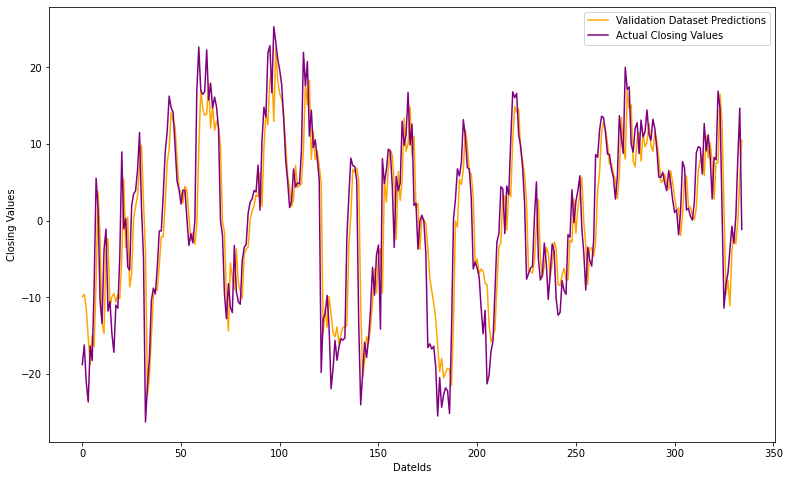

In [29]:
plt.figure(figsize = (13, 8))
plt.plot(val_results['Validation Predictions'], label = 'Validation Dataset Predictions', color = 'orange')
plt.plot(val_results['Actual Closing Values'], label = 'Actual Closing Values', color = 'purple')
plt.xlabel('DateIds')
plt.ylabel('Closing Values')
plt.legend()
plt.show()

### Predicting using the testing dataset 

In [30]:
test_predictions = lstm_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actual Closing Values':y_test})
test_results

,Test Predictions,Actual Closing Values
0,-0.319700,0.003995
1,0.314494,-0.535990
2,-1.007240,-1.351999
3,-3.978526,-11.971341
4,-5.621276,0.042671
...,...,...
413,-8.977662,-6.737337
414,-6.147244,6.385332
415,3.041502,5.300663
416,2.686451,11.216656


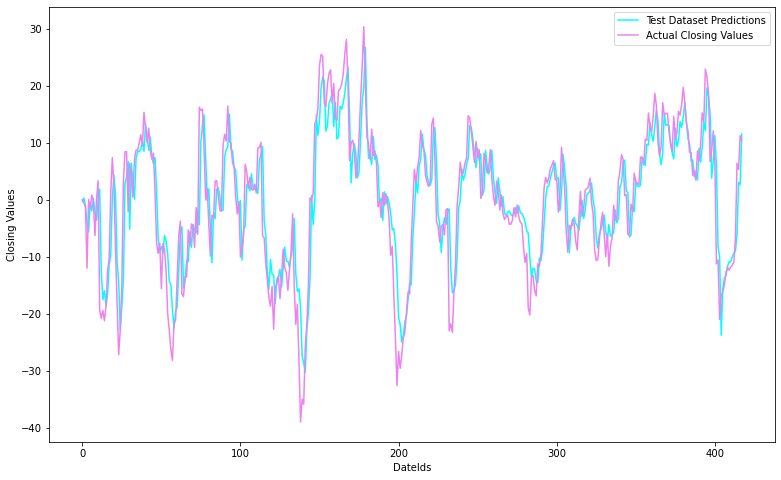

In [31]:
plt.figure(figsize = (13, 8))
plt.plot(test_results['Test Predictions'], label = 'Test Dataset Predictions', color = 'cyan')
plt.plot(test_results['Actual Closing Values'], label = 'Actual Closing Values', color = 'violet')
plt.xlabel('DateIds')
plt.ylabel('Closing Values')
plt.legend()
plt.show()

#### From the graph, it is very clear that the closing value predictions done by the model for the test datset coincides with the actual closing values of the test dataset. 

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test_results['Actual Closing Values'],test_results['Test Predictions']))
print(rmse)

5.483190107591595
